## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax


## Requesting freshness

In this portion, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

__Exercise 1.1__ (20 pts)

Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from apikeys import MY_KEY

In [4]:
import requests
import requests_cache

#cache your requests to be polite - it's a SQL lite database
requests_cache.install_cache("mycache")

# 2. Delay your requests (if you have a lot of them, in a loop)
import time
time.sleep(1)

In [5]:
def ndb_search(item, ds = ""):
    r = requests.get("https://api.nal.usda.gov/ndb/search/", params = {
    "api_key": MY_KEY,
    "q": item,
    "ds": ds,
    "format": "json"})
    r.raise_for_status()
    r = r.json()
    if "list" in r:
        if "item" in r["list"]:
            result = r['list']['item']
        else: 
            print('problem with ' + item + 'list does not contain item')
            return([])
    else:
        if 'errors' in r:
            if '_' in item:
                item2 = item.replace("_"," ")
                result = ndb_search(item2)

            else:
                print(item + ' not found')
                return([])
        else:
            print(r)
            return([])
    return(result)

__Exercise 1.2__ (20 pts)

Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

In [62]:
fresh = pd.read_csv('fresh.csv', header = 0)

In [7]:
kwds = fresh.iloc[:,5].values
for i in range(len(kwds)):
    if kwds[i] == kwds[i - 1]:
        kwds[i] = kwds[i] + "_" + fresh.iloc[i,0][6:-1]

In [8]:
def get_ndbnos(food, ds = "",raw = 0):
    ex1 = ndb_search(food,ds)
    if not (ex1 == None):
        ndbno_list = [] 
        names_list = []
        for entry in ex1:
            if raw == 1:
                if ", raw" not in entry['name']:
                    continue
            if 'ndbno' in entry:
                ndbno = entry['ndbno']
            else: 
                ndbno = np.nan
            ndbno_list.append(ndbno)
            names_list.append(entry['name'])
        return([ndbno_list, names_list])

In [9]:
food_li = []
ndb_li = []
name_li = []
for fruit in kwds:
    ndbno_list = get_ndbnos(fruit, ds = "Standard Reference", raw = 1)
    for x in ndbno_list[0]:
        ndb_li.append(x) 
        food_li.append(fruit)
        
    for y in ndbno_list[1]:
        name_li.append(y)
d = {'food': food_li, 'ndbnos': ndb_li, 'names': name_li}    
df = pd.DataFrame(data=d).drop_duplicates('food')
df.index = range(0,len(df.names))
df

,food,names,ndbnos
0,watermelon,"Watermelon, raw",09326
1,cantaloupe,"Melons, cantaloupe, raw",09181
2,tangerines,"Tangerines, (mandarin oranges), raw",09218
3,strawberries,"Strawberries, raw",09316
4,plums,"Plums, raw",09279
5,oranges,"Oranges, raw, California, valencias",09201
6,raspberries,"Raspberries, raw",09302
7,pomegranate,"Pomegranates, raw",09286
8,pineapple,"Pineapple, raw, all varieties",09266
9,apricots,"Apricots, raw",09021


I wrote a function that takes in the food and two other arguments which are passed to the ndb_search function. Those arguements are necessary for shortening the step where foods that are branded and or not raw are removed. I took an initial step to manipulate entries that are repeated for a reason. Those included Cucumbers and Cabbage. I manipulated them so that the second one would have a specifier, which was taken from the fresh column of the csv file. The second cabbage became cabbage_red and the second cucumbers became cucumbers_peeled. I also noticed that the squashes could be found if their underscores were removed. I added an if statement to tell my code when something elicited no results, to try removing the underscore and running it again if it had an underscore. This worked very well for acorn squash and summer squash. I collected three pieces of information from every search, each in a separate list: food (food), specifics (names), and ndb number (ndbnos). After they had been filled out for every food on the list that contatined a raw version, I created a dictionary that takes the item for every raw version that could be found with the search function on the list. Then I turned the dictionary into a pandas data frame, dropped duplicates of food items (a lot of them had multiple ndbnos associated, and for most of them, the first one was most relevant), and reset the index to make it look neater. 

__Exercise 1.3__ (20 pts)

Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

In [10]:
def ndb_report(ndbno):
    r = requests.get("https://api.nal.usda.gov/ndb/V2/reports", params = {
    "api_key": MY_KEY,      
    "ndbno": ndbno,       # takes in one food, if it takes it multiple foods only the first will be returned
    "type": "b",          # basic report
    "format": "json"})      # it's supposed to be default, but just in case
    r.raise_for_status()
    r = r.json()
    result = r['foods'][0]['food']['nutrients']   # this works well when only one food is entered (by ndb number)
    return(result)    # ndb_report2() is a more versatile function, but doesn't return exactly the right thing for raw plums.

__Exercise 1.4__ (20 pts) Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

In [15]:
def ndb_report2(ndbno):
    r = requests.get("https://api.nal.usda.gov/ndb/V2/reports", params = {
    "api_key": MY_KEY,
    "ndbno": ndbno,
    "type": "b",
    "format": "json"})        #from this function I can choose what I want to use
    r.raise_for_status()
    r = r.json()            #I am going to call use it a lot to build a data frame for nutrients
    result = r         #It's useful because I can feed it a list of ndbnos instead of just one
    return(result)    #And the result includes all of them

In [20]:
herp = ndb_report2(df.ndbnos)

In [60]:
indx = []
for x in df.food:
    inx = np.where(kwds == x)
    indx.append(inx[0][0])

In [129]:
fresh2 = fresh.copy().iloc[indx]

In [95]:
Protein = [0]*len(fresh2.type)
Carbohydrates = Protein.copy()
Fiber = Protein.copy()

for j in range(len(herp['foods'])):
    for nutrient in herp['foods'][j]['food']['nutrients']:
        if nutrient["name"] == 'Protein':
            Protein[j] = nutrient["value"]
        if nutrient["name"] == 'Carbohydrate, by difference':
            Carbohydrates[j] = nutrient["value"]
        if nutrient["name"] == 'Fiber, total dietary':
            Fiber[j] = nutrient["value"]    

['0.61', '0.84', '0.81', '0.67', '0.70', '1.04', '1.20', '1.67', '0.54', '1.40', '0.54', '0.47', '1.00', '1.09', '0.26', '0.91', '1.06', '0.36', '0.88', '1.39', '0.81', '0.74', '0.82', '2.20', '0.65', '0.59', '0.90', '1.10', '1.50', '2.86', '2.05', '0.80', '2.60', '1.43', '2.49', '1.20', '0.68', '1.96', '4.28', '3.27', '1.93', '3.38', '3.22']
['7.55', '8.16', '13.34', '7.68', '11.42', '11.89', '11.94', '18.70', '13.12', '11.12', '9.09', '10.82', '12.18', '22.84', '13.81', '9.54', '10.55', '15.23', '9.09', '9.61', '13.93', '14.49', '14.98', '3.88', '3.63', '2.16', '2.97', '9.34', '7.13', '4.67', '17.49', '10.42', '3.14', '7.37', '8.82', '3.84', '3.40', '8.64', '8.75', '10.51', '7.45', '8.95', '19.02']
['0.4', '0.9', '1.8', '2.0', '1.4', '2.5', '6.5', '4.0', '1.4', '2.0', '0.8', '1.7', '1.6', '2.6', '2.4', '1.5', '1.7', '3.1', 0, '5.3', '3.9', '2.4', '1.6', '2.1', '0.5', '0.7', '1.2', '1.7', '3.2', '3.2', '2.1', '1.5', '2.1', '2.1', '5.3', '1.2', '1.6', '6.8', '3.6', '5.4', '3.2', '3.8',

In [171]:
fresh3 = pd.DataFrame(data = {'type': fresh2.type,
                              'food': fresh2.food,
                              'form': fresh2.form,
                              'price_per_lb': fresh2.price_per_lb,
                              'lb_per_cup': fresh2.lb_per_cup, 
                              'price_per_cup': fresh2.loc[:,'price_per_cup'], 
                              'yield': fresh2.loc[:,'yield'],
                              'protein': Protein,
                              'carbohydrates': Carbohydrates,
                              'fiber': Fiber})
fresh3

,carbohydrates,fiber,food,form,lb_per_cup,price_per_cup,price_per_lb,protein,type,yield
0,7.55,0.4,watermelon,Fresh1,0.330693,0.212033,0.333412,0.61,fruit,0.520000
1,8.16,0.9,cantaloupe,Fresh1,0.374786,0.393800,0.535874,0.84,fruit,0.510000
2,13.34,1.8,tangerines,Fresh1,0.407855,0.759471,1.377962,0.81,fruit,0.740000
3,7.68,2.0,strawberries,Fresh1,0.319670,0.802171,2.358808,0.67,fruit,0.940000
4,11.42,1.4,plums,Fresh1,0.363763,0.707176,1.827416,0.70,fruit,0.940000
5,11.89,2.5,oranges,Fresh1,0.407855,0.578357,1.035173,1.04,fruit,0.730000
6,11.94,6.5,raspberries,Fresh1,0.319670,2.322874,6.975811,1.20,fruit,0.960000
7,18.70,4.0,pomegranate,Fresh1,0.341717,1.326342,2.173590,1.67,fruit,0.560000
8,13.12,1.4,pineapple,Fresh1,0.363763,0.447686,0.627662,0.54,fruit,0.510000
9,11.12,2.0,apricots,Fresh1,0.363763,1.189102,3.040072,1.40,fruit,0.930000


In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

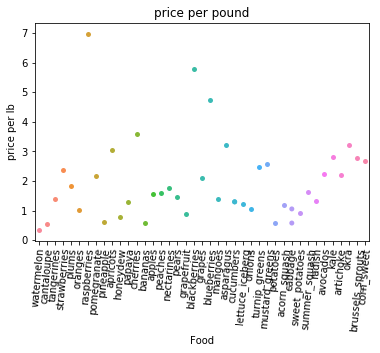

In [163]:
frable = fresh3.copy()
frable.index = frable.food
ax = sns.stripplot(x = frable["price_per_lb"].index, y = frable["price_per_lb"])
ax.set(title = "price per pound", xlabel = "Food", ylabel = "price per lb")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)
plt.show()

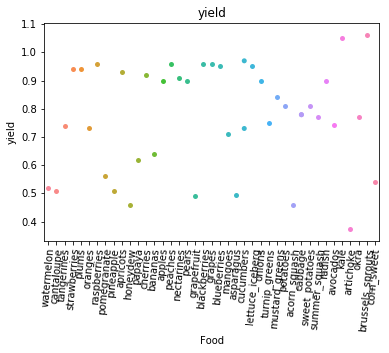

In [164]:
ax = sns.stripplot(x = frable["yield"].index, y = frable["yield"])
ax.set(title = "yield", xlabel = "Food", ylabel = "yield")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)
plt.show()

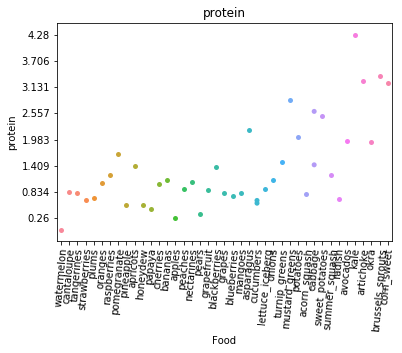

In [215]:
inde = np.linspace(float(min(frable.protein)),float(max(frable.protein)),8).round(3)
ax = sns.stripplot(x = frable["protein"].index, y = frable["protein"])
ax.set(title = "protein", xlabel = "Food", ylabel = "protein")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)
ax.set_yticks(inde)
ax.set_yticklabels(inde)
plt.show()

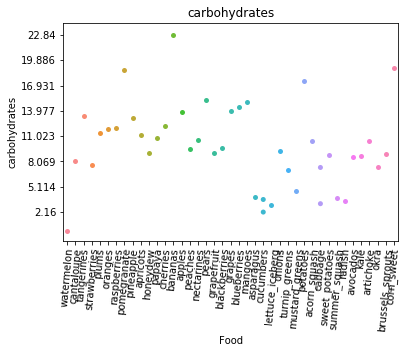

In [214]:
indb = np.linspace(2.16,22.84,8).round(3)
ax = sns.stripplot(x = frable["carbohydrates"].index, y = frable["carbohydrates"])
ax.set(title = "carbohydrates", xlabel = "Food", ylabel = 'carbohydrates')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)
ax.set_yticks(indb)
ax.set_yticklabels(indb)
plt.show()

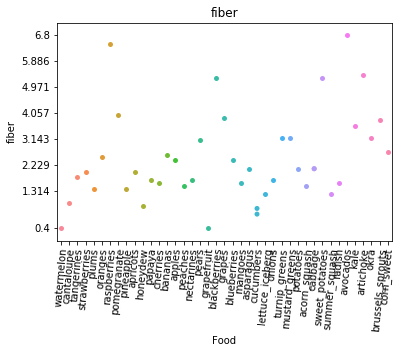

In [213]:
indz = np.linspace(0.4,6.8,8).round(3)
ax = sns.stripplot(x = frable["fiber"].index, y = frable["fiber"])
ax.set(title = "fiber", xlabel = "Food", ylabel = 'fiber')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)
ax.set_yticks(indz)
ax.set_yticklabels(indz)
plt.show()

In [290]:
fresh4= fresh3.copy()
fresh5 = fresh4.copy().drop(19,axis=0)
for i in fresh5.index:
    fresh5['fiber'] = float(i)
protein10 = fresh4.sort_values(by = 'protein').tail(10)
carbs10 = fresh4.sort_values(by = 'carbohydrates').tail(10)
fiber10 = fresh5.sort_values(by = 'fiber').tail(10)
yield10 = fresh4.sort_values(by = 'yield').tail(10)
ppp10 = fresh4.sort_values(by = 'price_per_lb').head(10)



In [295]:
print('protein', 
    protein10.food.values)
print('fiber',
    fiber10.food.values)
print('carbs',
      carbs10.food.values)
print('yield',
      yield10.food.values)
print('price per pound',
      ppp10.food.values)

score = protein10.food.append(fiber10.food).append(carbs10.food).append(yield10.food).append(ppp10.food)
score.values.sort()
print(score)

protein ['avocados' 'potatoes' 'asparagus' 'sweet_potatoes' 'cabbage'
 'mustard_greens' 'corn_sweet' 'artichoke' 'brussels_sprouts' 'kale']
fiber ['papaya' 'cherries' 'bananas' 'apples' 'peaches' 'nectarines' 'pears'
 'blackberries' 'honeydew' 'corn_sweet']
carbs ['cantaloupe' 'avocados' 'kale' 'sweet_potatoes' 'brussels_sprouts'
 'honeydew' 'grapefruit' 'onions' 'peaches' 'blackberries']
yield ['strawberries' 'lettuce_iceberg' 'blueberries' 'grapes' 'blackberries'
 'peaches' 'raspberries' 'cucumbers' 'kale' 'brussels_sprouts']
price per pound ['watermelon' 'cantaloupe' 'potatoes' 'bananas' 'cabbage' 'pineapple'
 'honeydew' 'grapefruit' 'sweet_potatoes' 'oranges']
42              apples
31           artichoke
24           asparagus
38            avocados
36            avocados
30             bananas
48             bananas
44        blackberries
47        blackberries
43        blackberries
11         blueberries
13    brussels_sprouts
14    brussels_sprouts
15    brussels_sprouts
16   

I took the top ten foods in each of the following categories: yield, price per pound (lowest), fiber content, protein content, and carbohydrates. The foods that appeared on the most lists were kale, blackberries, sweet potatoes, peaches, honeydew, and brussel sprouts. They each appear on four lists. The dot plots (far above) show evidence of this, but as they are small, I have left the table (fresh3) visible, and printed the list of top10 ranked foods (directly above) to assist. 

As far as root vegetables go, sweet potatoes might be the best investment. Blackberries, brussel sprouts, and kale are nutritionally quite valuable, but are some of the most expensive foods on the list, up there with avocado (which is a shame, because I have a terrific kale grapefruit guacamole recipe that I haven't had the chance to make in a while for lack of cheap avocados). Unsurprisingly, watermelon only makes the list for its low per-pound price. With such a high water content, there isn't much nutritional value per volume. Raspberries, quite high in fiber, are the most expensive fruit on the list. Unsurprisingly, artichoke has a very low yield. 

It surprises me that corn comes up twice times because as a food that is mostly cob, it would have low yield, and therefore, it must have won its place based on nutritional value. I can understand a high carbohydrate level, but I was really surprised by the high protein content. This is interesting because it is a food that is often mocked for lacking nutritional value.  